# Librerias

In [1]:
# %% Librerías
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter, defaultdict

from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score
from joblib import dump

import shap
shap.initjs()


warnings.filterwarnings('ignore')



/Users/andresmauriciotrianareina/miniconda3/envs/PruebaXolit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data

In [2]:
ruta_carpeta = 'data_prueba'
lista_dataframes = []

for archivo in os.listdir(ruta_carpeta):
    if archivo.endswith('.csv'):
        nombre_df = os.path.splitext(archivo)[0]
        ruta_completa = os.path.join(ruta_carpeta, archivo)
        try:
            df = pd.read_csv(ruta_completa, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(ruta_completa, encoding='latin1')
        globals()[nombre_df] = df
        lista_dataframes.append(nombre_df)

print(f"Se cargaron {len(lista_dataframes)} archivos CSV.")
print("Nombres de los DataFrames:", lista_dataframes)

Se cargaron 5 archivos CSV.
Nombres de los DataFrames: ['PobrezaCiudades', 'RazaCiudades', 'PoliciaAsesinatos', 'EducacionCiudades', 'IngresoCiudades']


In [3]:
##### Imprimir la informacion basica de cada dataframe

for nombre in lista_dataframes:
    print("####################### información de cada dataframe: ", nombre)
    print(f"DataFrame: {nombre}")
    df = globals()[nombre]  
    
    print("Información general:")
    print(df.info())

    print("Descripción estadística:")
    print(df.describe(include='all'))

    print("\Valores nulos por columna:")
    print(df.isnull().sum())
    

####################### información de cada dataframe:  PobrezaCiudades
DataFrame: PobrezaCiudades
Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29329 non-null  object
 1   City             29329 non-null  object
 2   poverty_rate     29329 non-null  object
dtypes: object(3)
memory usage: 687.5+ KB
None
Descripción estadística:
       Geographic Area           City poverty_rate
count            29329          29329        29329
unique              51          24255          771
top                 PA  Franklin city            0
freq              1762             16         1464
\Valores nulos por columna:
Geographic Area    0
City               0
poverty_rate       0
dtype: int64
####################### información de cada dataframe:  RazaCiudades
DataFrame: RazaCiudades
Información general:
<c

### Informacion basica del dataframe PoliciasAsesinados

In [4]:
PoliciaAsesinatos.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [5]:
len(PoliciaAsesinatos)

2535

In [6]:
PoliciaAsesinatos.describe()

,id,age
count,2535.000000,2458.000000
mean,1445.731755,36.605370
std,794.259490,13.030774
min,3.000000,6.000000
25%,768.500000,26.000000
50%,1453.000000,34.000000
75%,2126.500000,45.000000
max,2822.000000,91.000000


In [7]:
PoliciaAsesinatos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   int64  
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2458 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2340 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(1), 

### 7.	Utilizando el conjunto de datos proporcionado en la carpeta comprimida ZIP realice un notebook en Python o R donde haga un resumen que contenga la siguiente información:

### a.	Análisis descriptivo de las variables manner_of_death y armed utilizando características sociodemográficas (age, gender, race, etc)

In [8]:
PoliciaAsesinatos.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

#### Distribución de manner_of_death por grupo sociodemográfico

In [9]:
print("Distribución de 'manner_of_death' por género:")


conteo_abs = PoliciaAsesinatos.groupby('gender')['manner_of_death'].value_counts().unstack(fill_value=0)

# Proporciones (normalize=True)
conteo_prop = PoliciaAsesinatos.groupby('gender')['manner_of_death'].value_counts(normalize=True).unstack(fill_value=0)

# Formatear proporciones como porcentaje
conteo_prop = conteo_prop.applymap(lambda x: f"{x:.1%}")

# Combinar los dos DataFrames
resultado = conteo_abs.astype(str) + " (" + conteo_prop + ")"

# Mostrar la tabla final
resultado

Distribución de 'manner_of_death' por género:


manner_of_death,shot,shot and Tasered
gender,,
F,102 (95.3%),5 (4.7%)
M,2261 (93.1%),167 (6.9%)


In [10]:
print("Distribución de 'manner_of_death' por raza:")


conteo_abs = PoliciaAsesinatos.groupby('race')['manner_of_death'].value_counts().unstack(fill_value=0)

# Proporciones (normalize=True)
conteo_prop = PoliciaAsesinatos.groupby('race')['manner_of_death'].value_counts(normalize=True).unstack(fill_value=0)

# Formatear proporciones como porcentaje
conteo_prop = conteo_prop.applymap(lambda x: f"{x:.1%}")

# Combinar los dos DataFrames
resultado = conteo_abs.astype(str) + " (" + conteo_prop + ")"

# Mostrar la tabla final
resultado

Distribución de 'manner_of_death' por raza:


manner_of_death,shot,shot and Tasered
race,,
A,34 (87.2%),5 (12.8%)
B,577 (93.4%),41 (6.6%)
H,391 (92.4%),32 (7.6%)
N,31 (100.0%),0 (0.0%)
O,24 (85.7%),4 (14.3%)
W,1123 (93.5%),78 (6.5%)


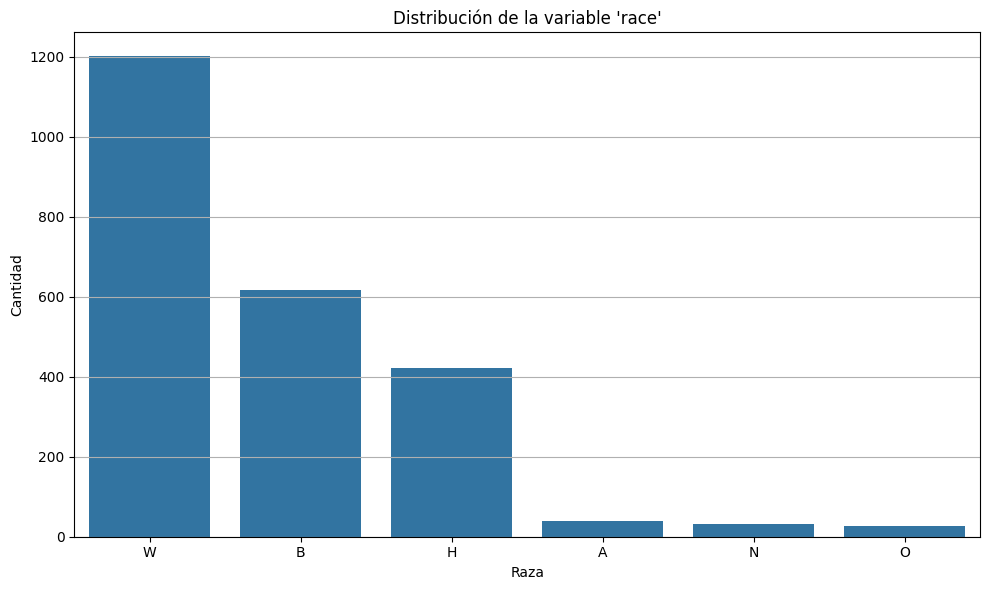

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=PoliciaAsesinatos, x='race', order=PoliciaAsesinatos['race'].value_counts().index)

plt.title("Distribución de la variable 'race'")
plt.xlabel("Raza")
plt.ylabel("Cantidad")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [12]:
print("Edad promedio por tipo de 'manner_of_death':")
print(PoliciaAsesinatos.groupby('manner_of_death')['age'].describe())

Edad promedio por tipo de 'manner_of_death':
                   count       mean        std   min   25%   50%   75%   max
manner_of_death                                                             
shot              2290.0  36.574672  13.090166   6.0  26.0  34.0  45.0  91.0
shot and Tasered   168.0  37.023810  12.221485  15.0  28.0  35.0  46.0  76.0


In [13]:
# Edad según tipo de muerte
# sns.boxplot(x='manner_of_death', y='age', data=PoliciaAsesinatos)
# plt.title("Distribución de edad por manner_of_death")
# plt.show()

In [14]:
print("Distribución de 'manner_of_death' por signos de enfermedad mental:")

conteo_abs = PoliciaAsesinatos.groupby('signs_of_mental_illness')['manner_of_death'].value_counts().unstack(fill_value=0)

# Proporciones (normalize=True)
conteo_prop = PoliciaAsesinatos.groupby('signs_of_mental_illness')['manner_of_death'].value_counts(normalize=True).unstack(fill_value=0)

# Formatear proporciones como porcentaje
conteo_prop = conteo_prop.applymap(lambda x: f"{x:.1%}")

# Combinar los dos DataFrames
resultado = conteo_abs.astype(str) + " (" + conteo_prop + ")"

# Mostrar la tabla final
resultado

Distribución de 'manner_of_death' por signos de enfermedad mental:


manner_of_death,shot,shot and Tasered
signs_of_mental_illness,,
False,1788 (94.0%),114 (6.0%)
True,575 (90.8%),58 (9.2%)


In [15]:
print("Distribución de 'manner_of_death' por nivel de amenaza:")

conteo_abs = PoliciaAsesinatos.groupby('threat_level')['manner_of_death'].value_counts().unstack(fill_value=0)

# Proporciones (normalize=True)
conteo_prop = PoliciaAsesinatos.groupby('threat_level')['manner_of_death'].value_counts(normalize=True).unstack(fill_value=0)

# Formatear proporciones como porcentaje
conteo_prop = conteo_prop.applymap(lambda x: f"{x:.1%}")

# Combinar los dos DataFrames
resultado = conteo_abs.astype(str) + " (" + conteo_prop + ")"

# Mostrar la tabla final
resultado

Distribución de 'manner_of_death' por nivel de amenaza:


manner_of_death,shot,shot and Tasered
threat_level,,
attack,1534 (95.2%),77 (4.8%)
other,679 (88.6%),87 (11.4%)
undetermined,150 (94.9%),8 (5.1%)


### Distribución de armed por grupo sociodemográfico

In [16]:
print("Proporción de personas armadas por género:")

conteo_abs = PoliciaAsesinatos.groupby('gender')['armed'].value_counts().unstack(fill_value=0)

# Proporciones (normalize=True)
conteo_prop = PoliciaAsesinatos.groupby('gender')['armed'].value_counts(normalize=True).unstack(fill_value=0)

# Formatear proporciones como porcentaje
conteo_prop = conteo_prop.applymap(lambda x: f"{x:.1%}")

# Combinar los dos DataFrames
resultado = conteo_abs.astype(str) + " (" + conteo_prop + ")"

# Mostrar la tabla final
resultado


Proporción de personas armadas por género:


armed,Taser,air conditioner,ax,baseball bat,baseball bat and bottle,baseball bat and fireplace poker,baton,bayonet,bean-bag gun,beer bottle,...,spear,stapler,straight edge razor,sword,tire iron,toy weapon,unarmed,undetermined,unknown weapon,vehicle
gender,,,,,,,,,,,,,,,,,,,,,
F,0 (0.0%),0 (0.0%),1 (0.9%),1 (0.9%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),...,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),7 (6.5%),11 (10.3%),2 (1.9%),1 (0.9%),12 (11.2%)
M,9 (0.4%),1 (0.0%),8 (0.3%),7 (0.3%),1 (0.0%),1 (0.0%),2 (0.1%),1 (0.0%),1 (0.0%),2 (0.1%),...,1 (0.0%),1 (0.0%),1 (0.0%),8 (0.3%),1 (0.0%),97 (4.0%),160 (6.6%),115 (4.8%),17 (0.7%),165 (6.8%)


In [17]:
print("Proporción de personas armadas por raza:")

conteo_abs = PoliciaAsesinatos.groupby('race')['armed'].value_counts().unstack(fill_value=0)

# Proporciones (normalize=True)
conteo_prop = PoliciaAsesinatos.groupby('race')['armed'].value_counts(normalize=True).unstack(fill_value=0)

# Formatear proporciones como porcentaje
conteo_prop = conteo_prop.applymap(lambda x: f"{x:.1%}")

# Combinar los dos DataFrames
resultado = conteo_abs.astype(str) + " (" + conteo_prop + ")"

# Mostrar la tabla final
resultado


Proporción de personas armadas por raza:


armed,knife,gun,vehicle,gun and knife,hammer,hatchet and gun,machete,pen,scissors,toy weapon,...,flashlight,garden tool,glass shard,lawn mower blade,machete and gun,metal rake,oar,pitchfork,pole and knife,straight edge razor
race,,,,,,,,,,,,,,,,,,,,,
A,15 (38.5%),12 (30.8%),3 (7.7%),1 (2.6%),1 (2.6%),1 (2.6%),1 (2.6%),1 (2.6%),1 (2.6%),1 (2.6%),...,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
B,69 (11.2%),353 (57.5%),45 (7.3%),2 (0.3%),1 (0.2%),0 (0.0%),4 (0.7%),0 (0.0%),0 (0.0%),24 (3.9%),...,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
H,70 (16.6%),206 (48.8%),30 (7.1%),2 (0.5%),1 (0.2%),0 (0.0%),5 (1.2%),0 (0.0%),1 (0.2%),13 (3.1%),...,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
N,6 (19.4%),18 (58.1%),2 (6.5%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (3.2%),1 (3.2%),...,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
O,9 (32.1%),11 (39.3%),3 (10.7%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),...,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
W,169 (14.1%),689 (57.4%),82 (6.8%),0 (0.0%),4 (0.3%),1 (0.1%),7 (0.6%),0 (0.0%),0 (0.0%),63 (5.2%),...,1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%),1 (0.1%)


In [18]:
print("Edad promedio según si estaban armados:")
Data_final = PoliciaAsesinatos.groupby('armed')['age'].describe()
Data_final

Edad promedio según si estaban armados:


,count,mean,std,min,25%,50%,75%,max
armed,,,,,,,,
Taser,9.0,44.333333,15.459625,20.0,36.0,38.0,57.00,69.0
air conditioner,1.0,41.000000,NaN,41.0,41.0,41.0,41.00,41.0
ax,9.0,42.000000,15.083103,21.0,35.0,40.0,56.00,62.0
baseball bat,8.0,37.250000,15.266677,19.0,27.5,36.0,41.25,66.0
baseball bat and bottle,1.0,29.000000,NaN,29.0,29.0,29.0,29.00,29.0
...,...,...,...,...,...,...,...,...
toy weapon,103.0,35.116505,13.369046,13.0,25.0,33.0,45.00,77.0
unarmed,170.0,30.882353,10.915937,6.0,23.0,29.0,37.00,73.0
undetermined,112.0,34.205357,11.811689,16.0,25.0,32.0,41.00,75.0


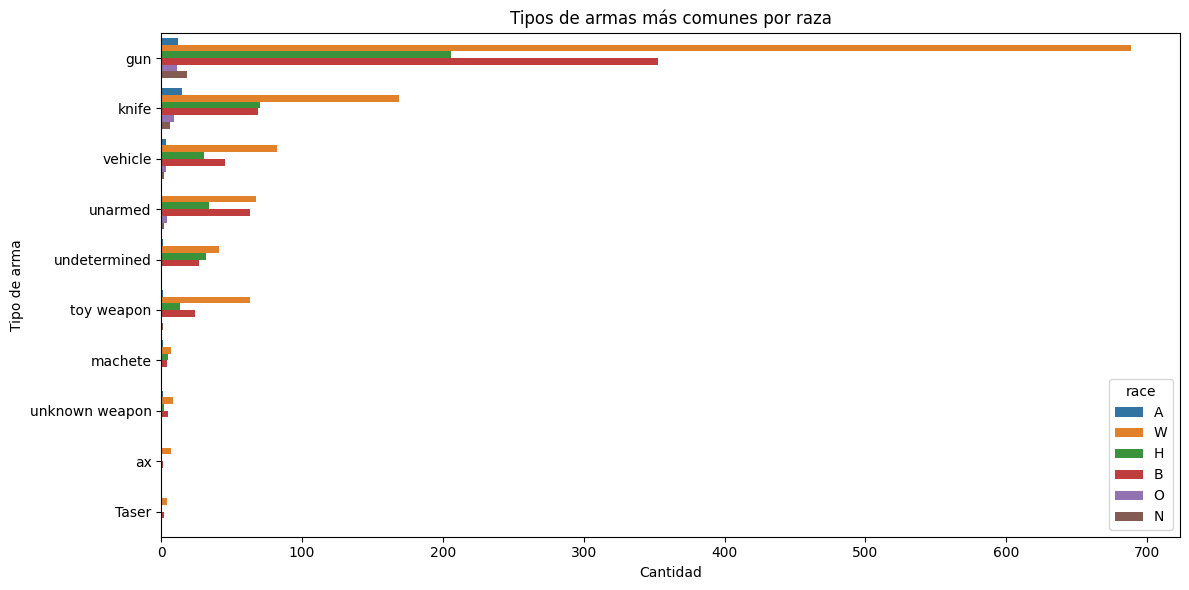

In [19]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    y='armed', 
    hue='race', 
    data=PoliciaAsesinatos, 
    order=PoliciaAsesinatos['armed'].value_counts().iloc[:10].index
)

plt.title("Tipos de armas más comunes por raza")
plt.xlabel("Cantidad")
plt.ylabel("Tipo de arma")

# Ajusta el margen izquierdo para que las etiquetas no se corten ni estén muy pegadas
plt.subplots_adjust(left=0.3)

plt.tight_layout()
plt.show()

### b.	Evolución en el tiempo de las muertes por estado (Seleccione los 5 estados con más muertes para facilitar la visualización)

In [20]:
PoliciaAsesinatos['date'] = pd.to_datetime(PoliciaAsesinatos['date'])

In [21]:
# Agrupar por estado y contar muertes
muertes_por_estado = PoliciaAsesinatos.groupby('state').size().sort_values(ascending=False)

# Seleccionar los 5 estados con más muertes
top_estados = muertes_por_estado.head(5).index

print("Top 5 estados con más muertes:")
muertes_por_estado.head(5)

Top 5 estados con más muertes:


state
CA    424
TX    225
FL    154
AZ    118
OH     79
dtype: int64

In [22]:
# Filtrar el DataFrame para esos 5 estados
df_top_estados = PoliciaAsesinatos[PoliciaAsesinatos['state'].isin(top_estados)]

# Crear una columna de mes
df_top_estados['mes'] = df_top_estados['date'].dt.to_period('M').dt.to_timestamp()

# Agrupar por mes y estado, contando muertes
muertes_mensuales = df_top_estados.groupby(['mes', 'state']).size().reset_index(name='muertes')


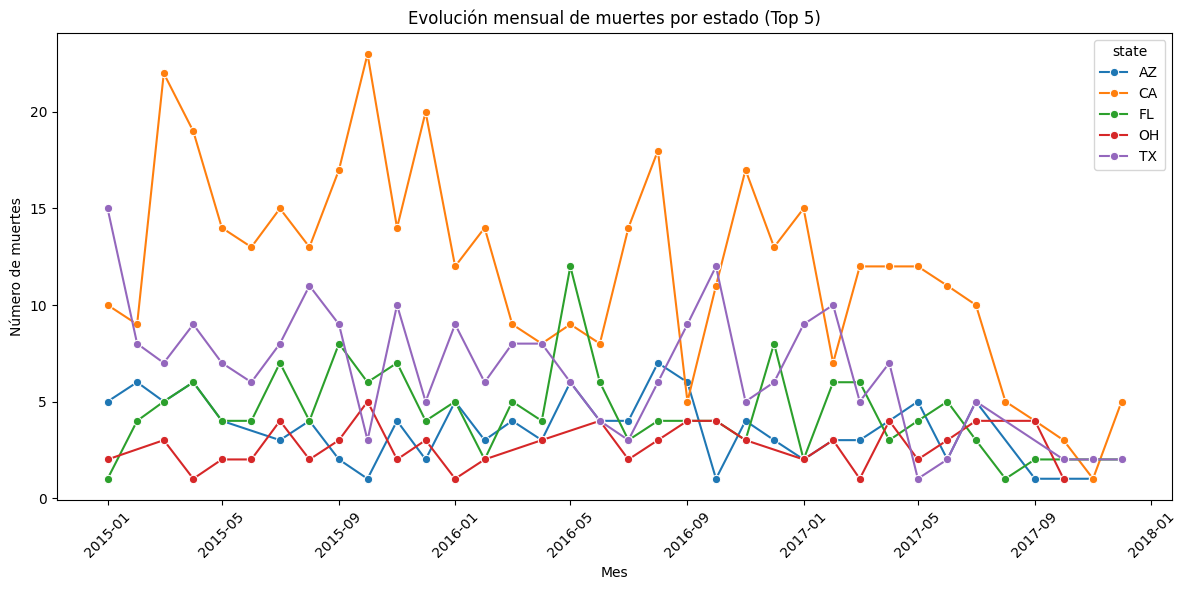

In [23]:
# Crear la gráfica
plt.figure(figsize=(12, 6))
sns.lineplot(data=muertes_mensuales, x='mes', y='muertes', hue='state', marker='o')

plt.title("Evolución mensual de muertes por estado (Top 5)")
plt.xlabel("Mes")
plt.ylabel("Número de muertes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### c.	Realice un análisis del ingreso, escolaridad, raza y pobreza para cada uno de los 5 estados

In [24]:
for df_name in ['IngresoCiudades', 'EducacionCiudades', 'PobrezaCiudades', 'RazaCiudades']:
    if df_name in globals():
        globals()[df_name].columns = globals()[df_name].columns.str.strip()

RazaCiudades.rename(columns={'Geographic area': 'Geographic Area'}, inplace=True)


In [25]:
# Unir los DataFrames progresivamente usando 'city' y 'state' como claves
merge1 = IngresoCiudades.merge(EducacionCiudades, on=['City', 'Geographic Area'], how='inner')
merge1 = merge1.merge(PobrezaCiudades, on=['City', 'Geographic Area'], how='inner')
merge1 = merge1.merge(RazaCiudades, on=['City', 'Geographic Area'], how='inner')
merge1.rename(columns={'Geographic Area': 'state', 'City': 'city'}, inplace=True)


In [26]:
columnas_a_convertir = ['Median Income', 'percent_completed_hs', 'poverty_rate',
                        'share_white', 'share_black', 'share_native_american',
                        'share_asian', 'share_hispanic']

for col in columnas_a_convertir:
    merge1[col] = pd.to_numeric(merge1[col], errors='coerce')
merge1.loc[merge1['Median Income'] < 0, 'Median Income'] = np.nan
merge1['city'] = merge1['city'].str.replace(r'\b(city|town|CDP|village)\b', '', regex=True).str.strip()
merge1.drop_duplicates(subset=['city', 'state'], inplace=True)

In [27]:
merge1.columns

Index(['state', 'city', 'Median Income', 'percent_completed_hs',
       'poverty_rate', 'share_white', 'share_black', 'share_native_american',
       'share_asian', 'share_hispanic'],
      dtype='object')

In [28]:
# Eliminar duplicados basados en City y Geographic Area
merge1 = merge1.drop_duplicates(subset=['city', 'state'])

# Verificar cambios
print(f"Datos después de eliminar duplicados: {merge1.shape}")

Datos después de eliminar duplicados: (29039, 10)


In [29]:
# merge1.to_csv('merge1.csv')

In [30]:
# Filtrar el DataFrame para que solo muestre datos de los top 5 estados
df_analisis_top_estados = merge1[merge1['state'].isin(top_estados)]
df_analisis_top_estados

,state,city,Median Income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
930,AZ,Aguila,26842.0,26.1,57.4,64.7,1.0,3.6,0.4,69.4
931,AZ,Ajo,32964.0,80.0,33.6,75.1,0.9,9.9,1.1,38.3
932,AZ,Ak Chin,NaN,100.0,12.1,0.0,0.0,100.0,0.0,3.3
933,AZ,Ak-Chin Village,25197.0,59.8,54.5,2.7,0.6,75.4,0.0,27.5
934,AZ,Alamo Lake,NaN,100.0,0.0,100.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
26091,TX,Zapata,37088.0,57.7,17.8,92.4,0.0,0.1,0.2,95.0
26092,TX,Zapata Ranch,49732.0,95.1,3.0,85.2,0.0,0.0,0.0,98.1
26093,TX,Zarate,NaN,100.0,0.0,100.0,0.0,0.0,0.0,100.0
26094,TX,Zavalla,28500.0,72.2,35.2,97.1,0.7,0.7,0.0,1.4


In [31]:
df_analisis_top_estados.columns

Index(['state', 'city', 'Median Income', 'percent_completed_hs',
       'poverty_rate', 'share_white', 'share_black', 'share_native_american',
       'share_asian', 'share_hispanic'],
      dtype='object')

In [32]:
# Agrupar por estado y obtener estadísticas descriptivas
resumen_estadistico = df_analisis_top_estados.groupby('state').describe()


# Mostrar sólo algunas columnas clave (ajustar los nombres reales según tus columnas)
columnas_clave = ['Median Income', 'percent_completed_hs', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']

for col in columnas_clave:
    print(f"Análisis por estado para la variable: {col}")
    display(df_analisis_top_estados.groupby('state')[col].describe())

Análisis por estado para la variable: Median Income


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,369.0,42557.360434,19569.770846,4511.0,30000.0,39028.0,50014.0,151184.0
CA,1331.0,62141.326071,32161.505471,6917.0,39935.0,54621.0,76177.0,241667.0
FL,880.0,49817.697727,23213.198151,11533.0,35191.5,44669.0,58769.0,223500.0
OH,1139.0,50339.158911,21185.267020,9316.0,37500.0,45458.0,57274.5,211000.0
TX,1527.0,51381.240341,27516.438718,9444.0,34755.0,44145.0,59167.0,236250.0


Análisis por estado para la variable: percent_completed_hs


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,441.0,80.449660,17.091929,0.0,73.000,84.1,92.8,100.0
CA,1482.0,81.987787,17.354004,0.0,74.500,87.5,94.6,100.0
FL,910.0,85.708242,10.942290,27.3,80.125,88.4,93.9,100.0
OH,1178.0,88.317063,7.679240,24.4,84.800,89.6,93.5,100.0
TX,1688.0,75.885249,19.268681,0.0,68.975,80.3,88.8,100.0


Análisis por estado para la variable: poverty_rate


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,441.0,25.641497,21.097179,0.0,9.6,20.30,38.200,100.0
CA,1482.0,17.116262,14.513799,0.0,6.9,13.40,23.975,100.0
FL,910.0,17.580659,12.080586,0.0,8.9,15.00,23.675,98.6
OH,1178.0,14.852462,10.879674,0.0,6.8,13.30,20.500,90.9
TX,1688.0,19.797927,16.898292,0.0,8.5,16.95,26.025,100.0


Análisis por estado para la variable: share_white


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,448.0,60.025670,38.142676,0.0,5.825,79.3,91.225,100.0
CA,1496.0,71.986230,18.993438,5.5,57.875,77.5,88.000,100.0
FL,913.0,78.724206,20.062685,0.5,69.500,85.7,93.600,100.0
OH,1180.0,92.812712,12.222085,1.7,93.500,96.6,97.900,100.0
TX,1720.0,82.469012,14.249106,4.9,75.875,85.8,92.525,100.0


Análisis por estado para la variable: share_black


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,448.0,0.957813,2.352624,0.0,0.0,0.4,0.9,38.1
CA,1496.0,2.698529,5.576722,0.0,0.4,0.9,2.5,84.8
FL,913.0,13.409748,18.364736,0.0,1.5,5.8,17.9,97.9
OH,1180.0,3.946441,11.179742,0.0,0.2,0.7,2.1,95.5
TX,1720.0,5.940930,10.605272,0.0,0.3,1.5,6.7,90.5


Análisis por estado para la variable: share_native_american


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,448.0,28.547098,41.634903,0.0,0.875,2.0,88.8,100.0
CA,1496.0,1.729078,3.309329,0.0,0.600,1.0,1.9,66.7
FL,913.0,0.456955,0.657863,0.0,0.200,0.3,0.5,11.8
OH,1180.0,0.214407,0.327448,0.0,0.000,0.1,0.3,4.8
TX,1720.0,0.663605,0.851997,0.0,0.200,0.5,0.9,13.8


Análisis por estado para la variable: share_asian


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,448.0,0.714955,1.204809,0.0,0.0,0.30,0.900,10.0
CA,1496.0,5.542513,9.405797,0.0,0.8,1.95,5.825,66.9
FL,913.0,1.625411,1.697260,0.0,0.5,1.20,2.100,13.9
OH,1180.0,0.749661,1.396205,0.0,0.0,0.30,0.800,15.3
TX,1720.0,1.020698,2.691337,0.0,0.0,0.30,0.800,40.9


Análisis por estado para la variable: share_hispanic


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AZ,448.0,20.128795,23.092917,0.0,3.975,11.95,25.80,98.8
CA,1496.0,29.446725,26.467026,0.0,8.500,18.90,43.25,98.9
FL,913.0,16.359693,19.210966,0.0,4.300,8.70,20.80,95.5
OH,1180.0,2.141695,3.339700,0.0,0.600,1.30,2.30,31.3
TX,1720.0,38.842267,33.696614,0.0,10.400,25.75,64.95,100.0


### 8.	Utilizando el mismo conjunto de datos del punto 8, implemente un modelo de aprendizaje

In [33]:
len(PoliciaAsesinatos)

2535

In [34]:
PoliciaAsesinatos.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

In [35]:
PoliciaAsesinatos['date'] = pd.to_datetime(PoliciaAsesinatos['date'])
PoliciaAsesinatos['city'] = PoliciaAsesinatos['city'].str.strip()
PoliciaAsesinatos['state'] = PoliciaAsesinatos['state'].str.strip()


In [36]:
# unir marge con la base de datos de asesinatos

df_merged = merge1.rename(columns={'City': 'city', 'Geographic Area': 'state', })

df_merged = PoliciaAsesinatos.merge(merge1, on=['city', 'state'], how='left')
df_merged['age_group'] = pd.cut(df_merged['age'], bins=[0, 18, 35, 50, 65, 100],
                                labels=["0-18", "19-35", "36-50", "51-65", "66+"])


df_merged.head()


,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,body_camera,Median Income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,age_group
0,3,Tim Elliot,2015-02-01,shot,gun,53.0,M,A,Shelton,WA,...,False,37072.0,80.1,28.6,78.9,0.8,3.7,1.1,19.2,51-65
1,4,Lewis Lee Lembke,2015-02-01,shot,gun,47.0,M,W,Aloha,OR,...,False,65765.0,88.1,14.9,70.9,2.6,1.0,8.9,21.1,36-50
2,5,John Paul Quintero,2015-03-01,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,False,45947.0,87.5,17.3,71.9,11.5,1.2,4.8,15.3,19-35
3,8,Matthew Hoffman,2015-04-01,shot,toy weapon,32.0,M,W,San Francisco,CA,...,False,81294.0,87.0,13.2,48.5,6.1,0.5,33.3,15.1,19-35
4,9,Michael Rodriguez,2015-04-01,shot,nail gun,39.0,M,H,Evans,CO,...,False,47791.0,76.3,16.6,76.5,0.9,1.2,0.9,43.1,36-50


In [37]:
df_merged.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'Median Income', 'percent_completed_hs',
       'poverty_rate', 'share_white', 'share_black', 'share_native_american',
       'share_asian', 'share_hispanic', 'age_group'],
      dtype='object')

In [38]:
## Nuevas variables para el calculo

# df_merged['ingreso_pobreza'] = df_merged['Median Income'] / (df_merged['poverty_rate'] + 1)
# df_merged['educacion_ingreso'] = df_merged['percent_completed_hs'] * df_merged['Median Income']
# df_merged['edad_alta_pobreza'] = df_merged['age'] * df_merged['poverty_rate']

In [39]:
# elimniar filas que no tiene como dato la raza

print("Antes:", df_merged.shape)
df_merged = df_merged.dropna(subset=['race']).reset_index(drop=True)
print("Después:", df_merged.shape)

Antes: (2535, 23)
Después: (2340, 23)


In [40]:
# Reemplazar NaN por la media en columnas numéricas para entrenaqr el modelo
columnas_numericas = ['Median Income', 'percent_completed_hs', 'poverty_rate',
                      'share_white', 'share_black', 'share_native_american',
                      'share_asian', 'share_hispanic']

for col in columnas_numericas:
    if col in df_merged.columns:
        media = df_merged[col].mean()
        df_merged[col] = df_merged[col].fillna(media)

In [41]:
df_merged.tail()


,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,body_camera,Median Income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,age_group
2335,2808,Kesharn K. Burney,2017-07-26,shot,vehicle,25.0,M,B,Dayton,OH,...,False,27683.000000,82.100000,35.500000,51.700000,42.900000,0.300000,0.900000,3.000000,19-35
2336,2820,Deltra Henderson,2017-07-27,shot,gun,39.0,M,B,Homer,LA,...,False,27050.000000,79.000000,40.000000,33.000000,64.300000,0.100000,0.800000,1.400000,36-50
2337,2812,Alejandro Alvarado,2017-07-27,shot,knife,NaN,M,H,Chowchilla,CA,...,False,34559.000000,68.300000,32.100000,61.600000,12.600000,2.000000,2.100000,37.800000,NaN
2338,2817,Isaiah Tucker,2017-07-31,shot,vehicle,28.0,M,B,Oshkosh,WI,...,True,42650.000000,89.300000,17.900000,90.500000,3.100000,0.800000,3.200000,2.700000,19-35
2339,2815,Dwayne Jeune,2017-07-31,shot,knife,32.0,M,B,Brooklyn,NY,...,False,48659.573609,84.124177,19.698575,66.436708,15.647469,1.508747,4.527518,20.890369,19-35


In [42]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       2340 non-null   int64         
 1   name                     2340 non-null   object        
 2   date                     2340 non-null   datetime64[ns]
 3   manner_of_death          2340 non-null   object        
 4   armed                    2334 non-null   object        
 5   age                      2311 non-null   float64       
 6   gender                   2340 non-null   object        
 7   race                     2340 non-null   object        
 8   city                     2340 non-null   object        
 9   state                    2340 non-null   object        
 10  signs_of_mental_illness  2340 non-null   bool          
 11  threat_level             2340 non-null   object        
 12  flee                     2288 non-

In [43]:
len(df_merged)

2340

In [44]:
df_merged.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'Median Income', 'percent_completed_hs',
       'poverty_rate', 'share_white', 'share_black', 'share_native_american',
       'share_asian', 'share_hispanic', 'age_group'],
      dtype='object')

In [45]:
# df_merged.to_csv('final.csv')

#### Verifica correlacion de las variables

In [46]:
correlation_matrix = df_merged.corr(numeric_only=True)
correlation_matrix

,id,age,signs_of_mental_illness,body_camera,Median Income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
id,1.000000,0.010599,-0.037150,0.047940,-0.004770,0.024991,0.002453,0.015715,-0.004294,0.015900,-0.014239,-0.062776
age,0.010599,1.000000,0.111080,-0.026333,-0.015796,0.030189,-0.038868,0.171451,-0.093432,-0.030416,-0.085616,-0.083539
signs_of_mental_illness,-0.037150,0.111080,1.000000,0.018258,0.080946,0.089471,-0.062300,0.062957,-0.048772,-0.017451,0.032469,-0.052236
body_camera,0.047940,-0.026333,0.018258,1.000000,-0.009578,0.003783,0.038337,-0.046132,0.021981,0.032967,0.023308,0.002545
Median Income,-0.004770,-0.015796,0.080946,-0.009578,1.000000,0.428322,-0.751862,0.064709,-0.266253,-0.067133,0.472302,0.013956
percent_completed_hs,0.024991,0.030189,0.089471,0.003783,0.428322,1.000000,-0.549402,0.358586,-0.102937,-0.036720,0.040830,-0.622987
poverty_rate,0.002453,-0.038868,-0.062300,0.038337,-0.751862,-0.549402,1.000000,-0.337982,0.367680,0.086223,-0.214346,0.136661
share_white,0.015715,0.171451,0.062957,-0.046132,0.064709,0.358586,-0.337982,1.000000,-0.718046,-0.154989,-0.358817,-0.230101
share_black,-0.004294,-0.093432,-0.048772,0.021981,-0.266253,-0.102937,0.367680,-0.718046,1.000000,-0.123470,-0.127771,-0.222308
share_native_american,0.015900,-0.030416,-0.017451,0.032967,-0.067133,-0.036720,0.086223,-0.154989,-0.123470,1.000000,-0.066681,-0.036970


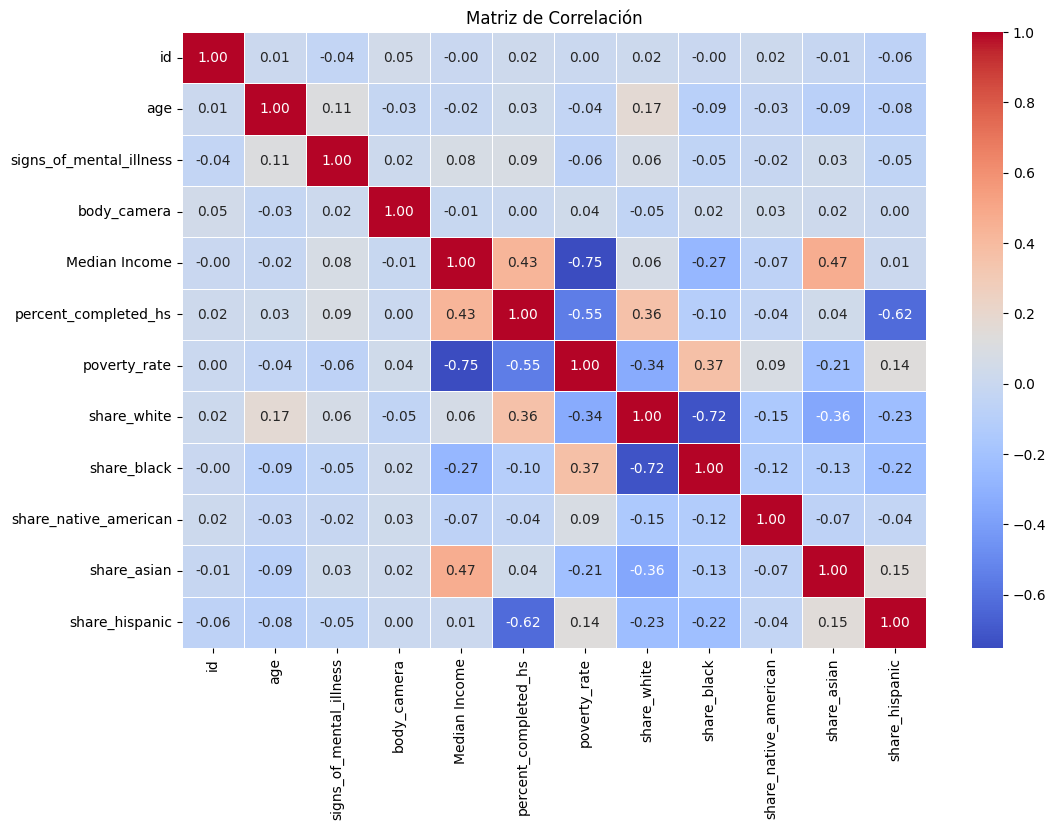

In [47]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [48]:
# Convertir a serie y filtrar pares duplicados y autocorrelaciones
correlation_pairs = correlation_matrix.abs().unstack()
correlation_pairs = correlation_pairs[correlation_pairs < 1]  # excluir la diagonal
high_corr = correlation_pairs[correlation_pairs > 0.8].sort_values(ascending=False)

print("Pares con alta correlación:")
print(high_corr)


Pares con alta correlación:
Series([], dtype: float64)


## Entrenamiento modelo

In [49]:
X = df_merged.drop(columns=['race', 'id', 'name', 'date'])

y = df_merged['race']

In [50]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Modelos con hold out

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [52]:
# y_train_encoded = le.fit_transform(y_train)
# y_test_encoded = le.transform(y_test)

In [53]:
X_train

,manner_of_death,armed,age,gender,city,state,signs_of_mental_illness,threat_level,flee,body_camera,Median Income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,age_group
787,shot,gun,36.0,M,Talking Rock,GA,False,attack,Not fleeing,False,42500.000000,76.700000,6.700000,100.000000,0.000000,0.000000,0.000000,0.000000,36-50
1503,shot,knife,24.0,M,San Bernardino,CA,True,other,Not fleeing,False,37047.000000,68.200000,33.400000,45.600000,15.000000,1.300000,4.000000,60.000000,19-35
1187,shot,gun,28.0,M,South Greensburg,PA,True,attack,Car,False,48659.573609,84.124177,19.698575,66.436708,15.647469,1.508747,4.527518,20.890369,19-35
679,shot,gun,45.0,M,West Knox,TN,False,attack,Not fleeing,False,48659.573609,84.124177,19.698575,66.436708,15.647469,1.508747,4.527518,20.890369,36-50
65,shot,gun,33.0,M,Columbus,OH,False,attack,Not fleeing,False,45659.000000,88.500000,21.700000,61.500000,28.000000,0.300000,4.100000,5.600000,19-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,shot,gun,56.0,M,Wood County,TX,True,attack,Not fleeing,False,48659.573609,84.124177,19.698575,66.436708,15.647469,1.508747,4.527518,20.890369,51-65
1095,shot,gun,31.0,M,Elizabethton,TN,False,attack,Not fleeing,False,30217.000000,81.900000,23.700000,94.000000,3.100000,0.100000,0.600000,2.000000,19-35
1130,shot,gun,37.0,M,Gautier,MS,False,attack,Not fleeing,False,44675.000000,88.400000,15.200000,61.100000,32.400000,0.500000,1.500000,5.300000,36-50
1294,shot,knife,59.0,M,Visalia,CA,False,other,Not fleeing,False,52157.000000,82.700000,21.300000,64.500000,2.100000,1.400000,5.400000,46.000000,51-65


In [54]:
# Columnas numéricas y categóricas
numerical = ['age', 'Median Income', 'percent_completed_hs', 'poverty_rate',
             'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']
categorical = ['manner_of_death', 'armed', 'gender', 'city', 'state',
               'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical)
])

In [55]:

conteo_actual = Counter(y_train)
clase_mayoritaria = max(conteo_actual, key=conteo_actual.get)
max_valor = conteo_actual[clase_mayoritaria]

strategy = {}
for clase, valor in conteo_actual.items():
    if clase == clase_mayoritaria:
        strategy[clase] = valor
    else:
        strategy[clase] = min(int(valor * 1.4), int(max_valor * 0.9))

ros = RandomOverSampler(sampling_strategy=strategy, random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)


print("Distribución después del oversampling:", Counter(y_train_over))

Distribución después del oversampling: Counter({np.int64(5): 971, np.int64(1): 681, np.int64(2): 464, np.int64(0): 46, np.int64(3): 35, np.int64(4): 33})


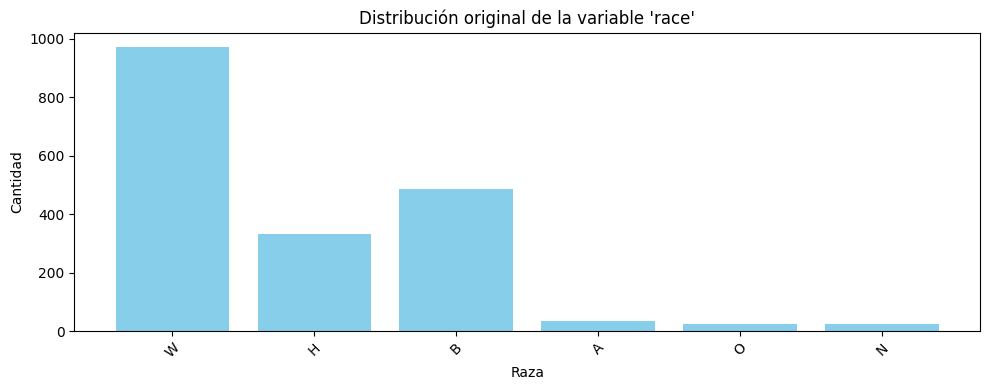

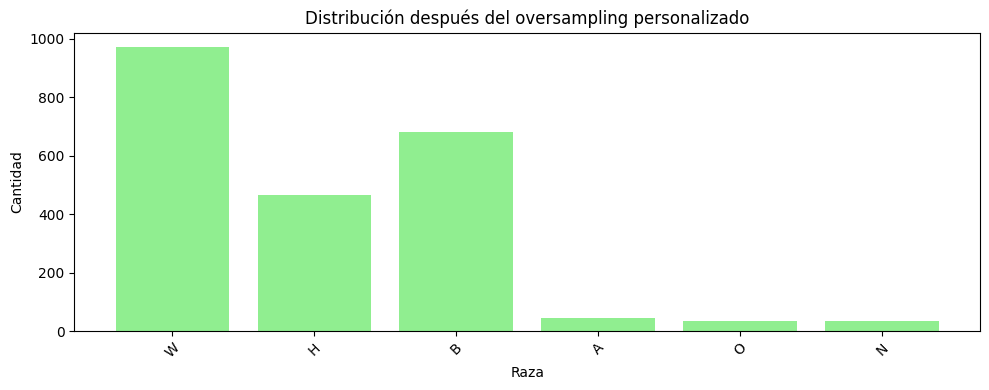

In [56]:
etiquetas_race = le.classes_  # le es tu LabelEncoder()
valores_originales = {i: etiqueta for i, etiqueta in enumerate(etiquetas_race)}

# Gráfica antes del oversampling
plt.figure(figsize=(10, 4))
plt.bar([valores_originales[i] for i in conteo_actual.keys()],
        conteo_actual.values(), color='skyblue')
plt.title("Distribución original de la variable 'race'")
plt.xlabel("Raza")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica después del oversampling
conteo_nuevo = Counter(y_train_over)
plt.figure(figsize=(10, 4))
plt.bar([valores_originales[i] for i in conteo_nuevo.keys()],
        conteo_nuevo.values(), color='lightgreen')
plt.title("Distribución después del oversampling personalizado")
plt.xlabel("Raza")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [58]:
results = {
    "Model": [],
    "Accuracy": [],
    "F1 Score": [],
    "Recall": [],
    
}


🔍 Entrenando modelo: LogisticRegression


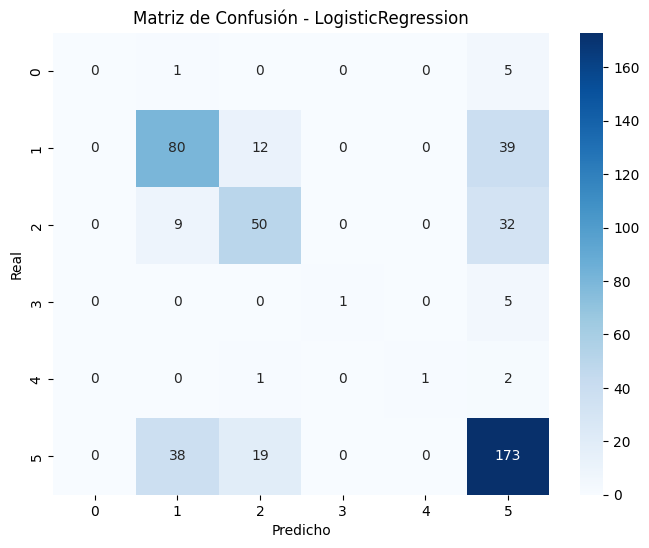

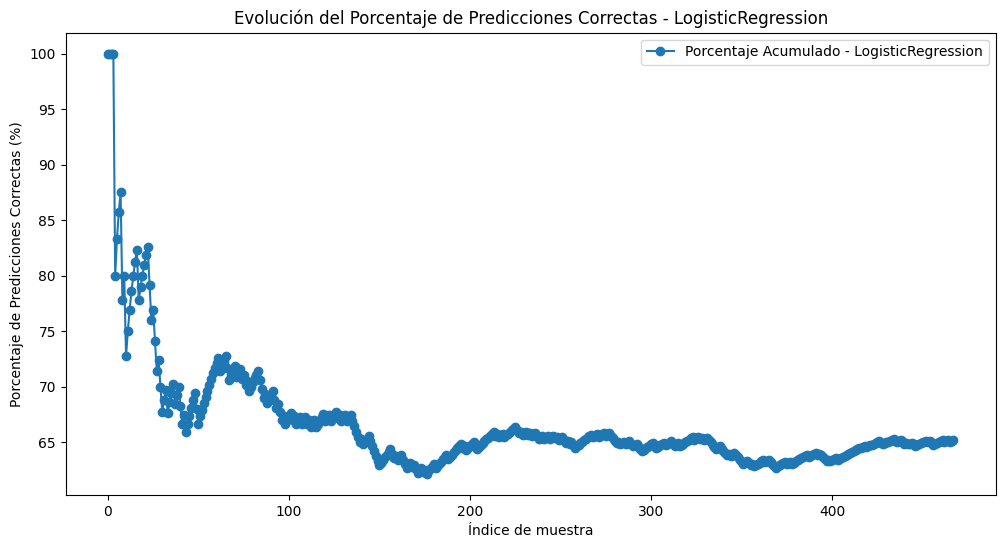


🔍 Entrenando modelo: SVC


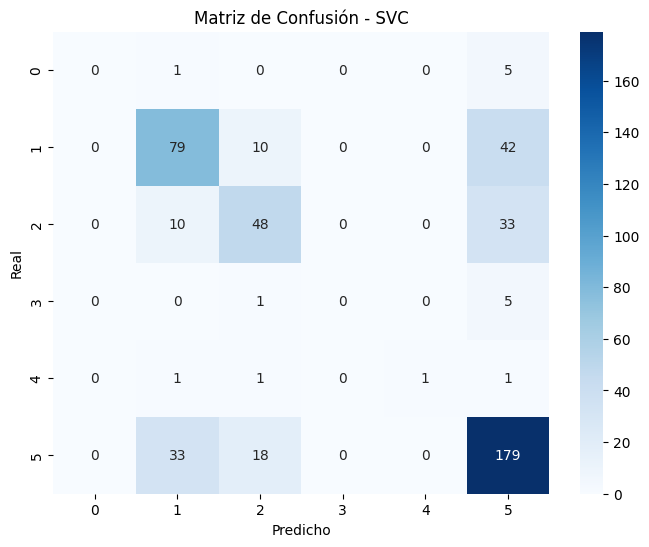

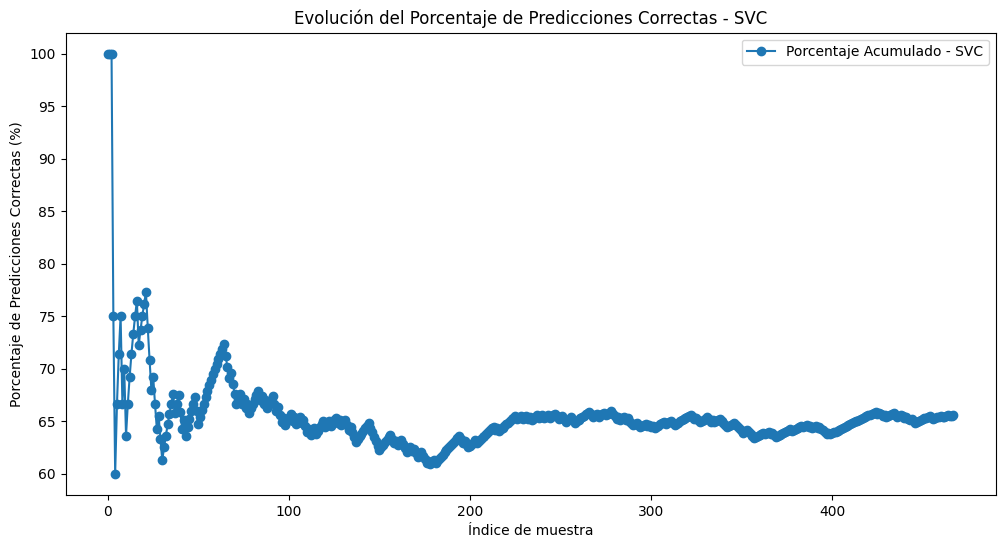


🔍 Entrenando modelo: DecisionTree


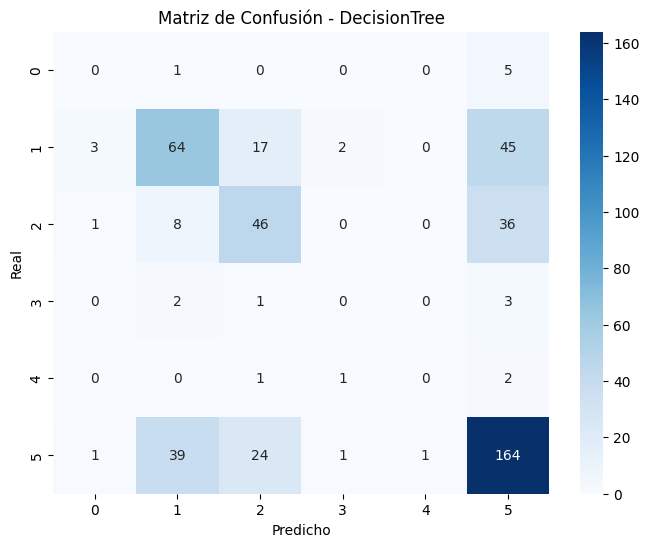

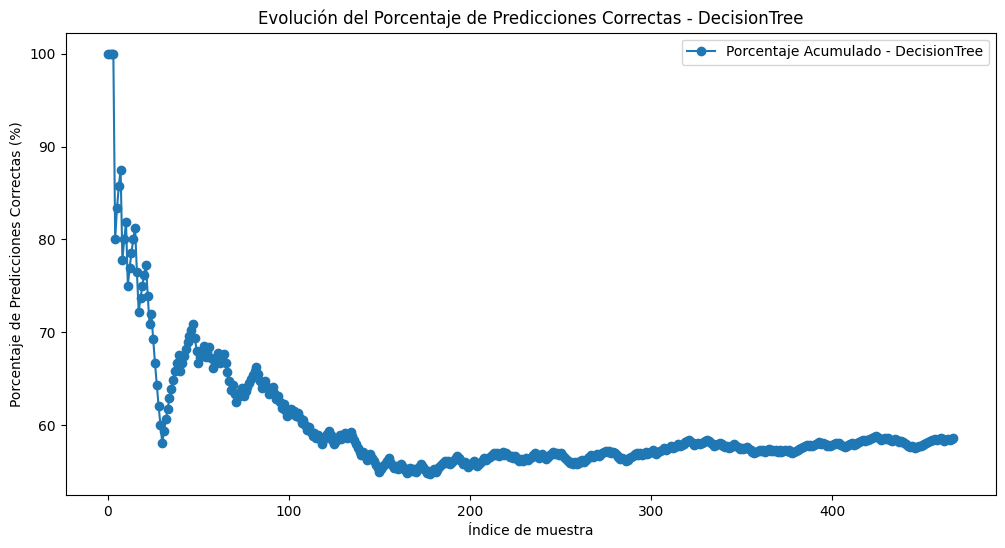


🔍 Entrenando modelo: RandomForest


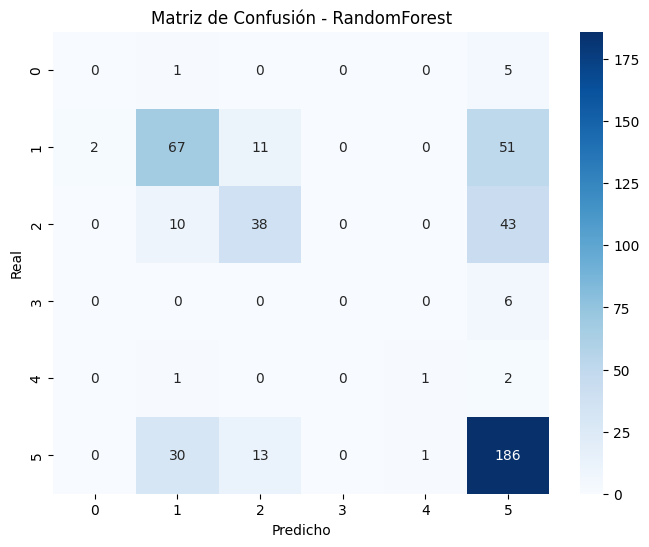

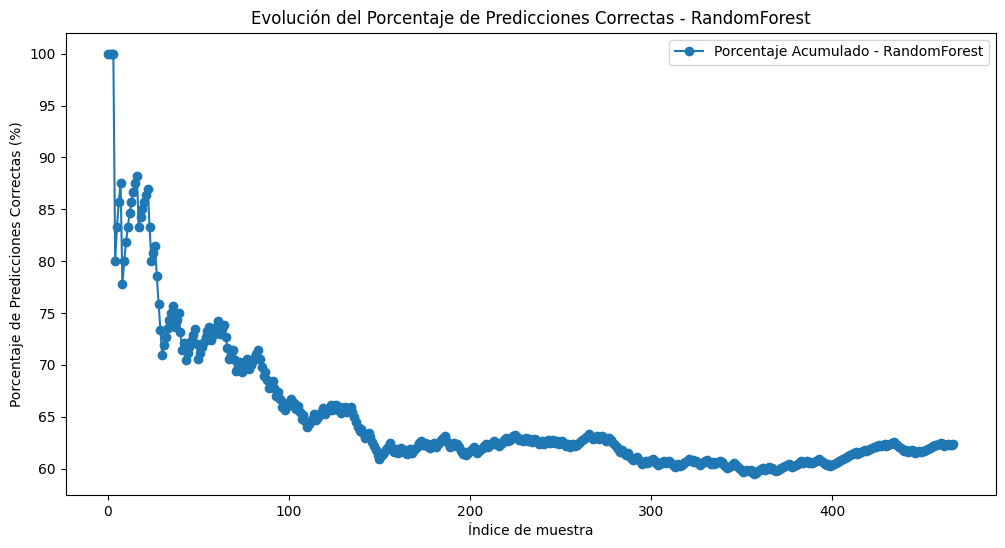


🔍 Entrenando modelo: XGBoost


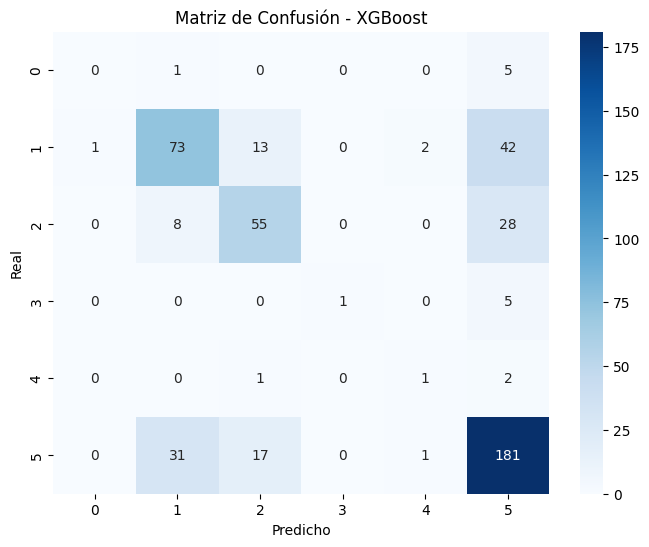

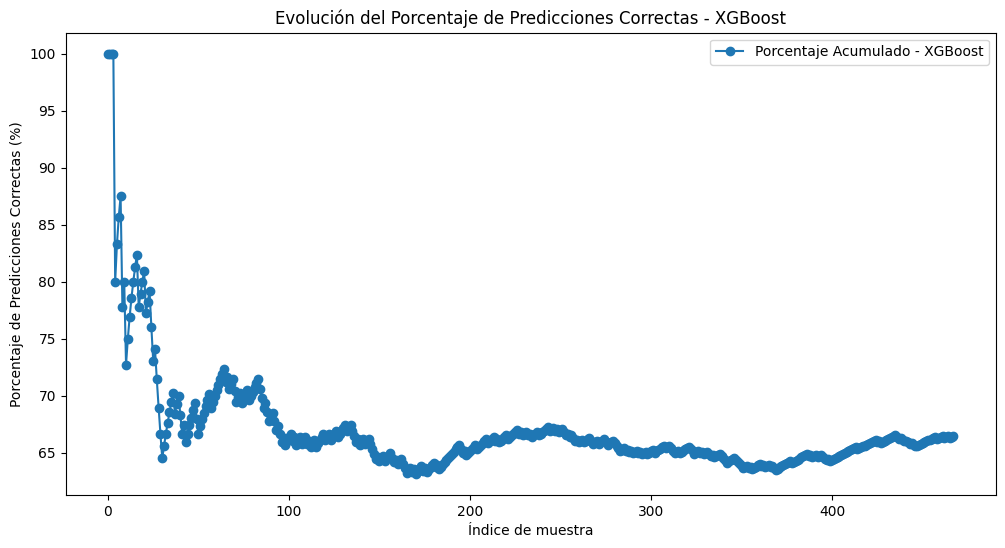

In [59]:
percentage_df = pd.DataFrame()
precision_per_label_df = pd.DataFrame()

for name, clf in models.items():
    print(f"\n🔍 Entrenando modelo: {name}")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipeline.fit(X_train_over, y_train_over)
    y_pred = pipeline.predict(X_test)

    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test, y_pred, average='weighted'))

    # 📌 Precisión por etiqueta
    labels = sorted(np.unique(y_test))  # Asegura orden correcto
    precision_per_class = precision_score(y_test, y_pred, average=None, labels=labels)
    precision_per_label_df[name] = precision_per_class

    # 🔢 Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # 📈 Porcentaje acumulado
    correct_predictions = (y_pred == y_test).cumsum()
    percentage_correct = correct_predictions / np.arange(1, len(y_pred) + 1) * 100
    percentage_df[name] = percentage_correct

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_pred)), percentage_correct, label=f'Porcentaje Acumulado - {name}', marker='o')
    plt.xlabel("Índice de muestra")
    plt.ylabel("Porcentaje de Predicciones Correctas (%)")
    plt.title(f"Evolución del Porcentaje de Predicciones Correctas - {name}")
    plt.legend()
    plt.show()

    dump(pipeline, f"models/{name}_modelo.joblib")

In [60]:
# Paso 8: Resultados finales
df_results_holdout = pd.DataFrame(results)
df_results_holdout.to_csv("resultados_modelos_holdout.csv", index=False)
df_results_holdout

,Model,Accuracy,F1 Score,Recall
0,LogisticRegression,0.651709,0.642280,0.651709
1,SVC,0.655983,0.642744,0.655983
2,DecisionTree,0.585470,0.577988,0.585470
3,RandomForest,0.623932,0.605283,0.623932
4,XGBoost,0.664530,0.654995,0.664530


<Figure size 1000x600 with 0 Axes>

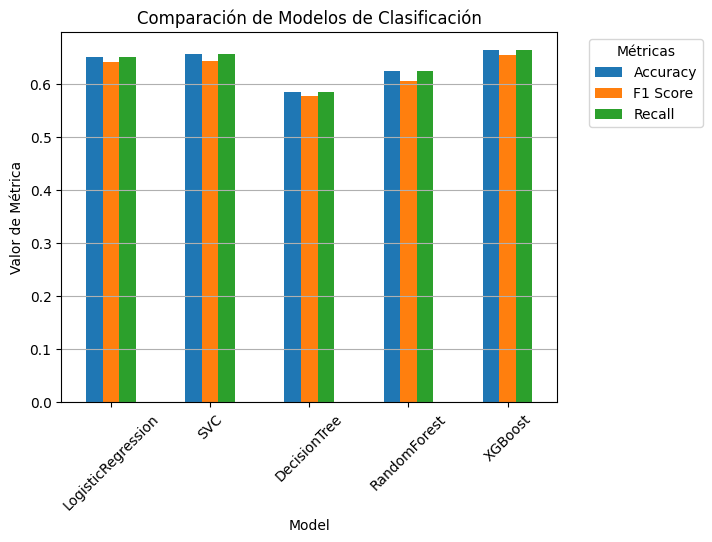

In [61]:
# Métricas de clasificación
plt.figure(figsize=(10, 6))
df_results_holdout[['Model', 'Accuracy', 'F1 Score', 'Recall']].set_index("Model").plot(kind="bar")
plt.title("Comparación de Modelos de Clasificación")
plt.ylabel("Valor de Métrica")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.legend(title="Métricas", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [62]:
# Verificar el precision_score por cada clase


# Asignar etiquetas reales como índice
etiquetas_reales = le.inverse_transform(labels)
precision_per_label_df.index = etiquetas_reales

print("\n📋 Precisión por etiqueta (etiquetas reales):")
display(precision_per_label_df)



📋 Precisión por etiqueta (etiquetas reales):


,LogisticRegression,SVC,DecisionTree,RandomForest,XGBoost
A,0.000000,0.000000,0.000000,0.000000,0.000000
B,0.625000,0.637097,0.561404,0.614679,0.646018
H,0.609756,0.615385,0.516854,0.612903,0.639535
N,1.000000,0.000000,0.000000,0.000000,1.000000
O,1.000000,1.000000,0.000000,0.500000,0.250000
W,0.675781,0.675472,0.643137,0.634812,0.688213


### Modelo con validacion cruzada

In [63]:
# Definir el número de divisiones para la validación cruzada
n_splits = 5 

# Usar StratifiedKFold para clasificación, para mantener la proporción de clases
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [64]:
results_cv = {
    "Model": [],
    "Accuracy_mean": [],
    "Accuracy_std": [],
    "F1_Score_mean": [],
    "F1_Score_std": [],
    "Recall_mean": [],
    "Recall_std": [],
}

In [65]:
from imblearn.pipeline import Pipeline as ImbPipeline

precision_labels_cv = defaultdict(list)  # Almacena precisión por clase para cada modelo

for name, clf in models.items():
    print(f"- Ejecutando Validación Cruzada para: {name}")

    pipeline_cv = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampler', RandomOverSampler(sampling_strategy=strategy, random_state=42)),
        ('classifier', clf)
    ])

    acc_scores, f1_scores, recall_scores = [], [], []
    precisiones_por_etiqueta = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        pipeline_cv.fit(X_train, y_train)
        y_pred = pipeline_cv.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))

        # Precisión por clase para este fold
        labels = sorted(np.unique(y_encoded))
        precision = precision_score(y_test, y_pred, average=None, labels=labels)
        precisiones_por_etiqueta.append(precision)

    # Promedio de métricas generales
    results_cv['Model'].append(name)
    results_cv['Accuracy_mean'].append(np.mean(acc_scores))
    results_cv['Accuracy_std'].append(np.std(acc_scores))
    results_cv['F1_Score_mean'].append(np.mean(f1_scores))
    results_cv['F1_Score_std'].append(np.std(f1_scores))
    results_cv['Recall_mean'].append(np.mean(recall_scores))
    results_cv['Recall_std'].append(np.std(recall_scores))

    print(f"   Accuracy (media +/- std): {np.mean(acc_scores):.4f} +/- {np.std(acc_scores):.4f}")
    print(f"   F1-Score (media +/- std): {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
    print(f"   Recall (media +/- std): {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")

    # Precisión promedio por clase para este modelo
    mean_precision = np.mean(precisiones_por_etiqueta, axis=0)
    precision_labels_cv[name] = mean_precision

    dump(pipeline_cv, f"models/{name}_modelo_cv.joblib")

# Crear DataFrame de precisión por clase
precision_labels_df = pd.DataFrame(precision_labels_cv, index=labels)
print("Precisión por etiqueta (promedio validación cruzada):")
display(precision_labels_df)




- Ejecutando Validación Cruzada para: LogisticRegression
   Accuracy (media +/- std): 0.6466 +/- 0.0116
   F1-Score (media +/- std): 0.6378 +/- 0.0135
   Recall (media +/- std): 0.6466 +/- 0.0116
- Ejecutando Validación Cruzada para: SVC
   Accuracy (media +/- std): 0.6624 +/- 0.0115
   F1-Score (media +/- std): 0.6473 +/- 0.0125
   Recall (media +/- std): 0.6624 +/- 0.0115
- Ejecutando Validación Cruzada para: DecisionTree
   Accuracy (media +/- std): 0.5688 +/- 0.0143
   F1-Score (media +/- std): 0.5659 +/- 0.0133
   Recall (media +/- std): 0.5688 +/- 0.0143
- Ejecutando Validación Cruzada para: RandomForest
   Accuracy (media +/- std): 0.6393 +/- 0.0117
   F1-Score (media +/- std): 0.6219 +/- 0.0135
   Recall (media +/- std): 0.6393 +/- 0.0117
- Ejecutando Validación Cruzada para: XGBoost
   Accuracy (media +/- std): 0.6402 +/- 0.0143
   F1-Score (media +/- std): 0.6290 +/- 0.0163
   Recall (media +/- std): 0.6402 +/- 0.0143
Precisión por etiqueta (promedio validación cruzada):


,LogisticRegression,SVC,DecisionTree,RandomForest,XGBoost
0,0.066667,0.000000,0.000000,0.000000,0.000000
1,0.602475,0.637196,0.496759,0.615330,0.600723
2,0.528464,0.552998,0.461934,0.527557,0.540669
3,0.500000,0.100000,0.068571,0.000000,0.250000
4,0.600000,0.800000,0.152302,0.583333,0.500000
5,0.718102,0.709156,0.675861,0.684120,0.699646


In [66]:
# Convertir los resultados de la validación cruzada a un DataFrame
df_results_crossvalidation = pd.DataFrame(results_cv)
df_results_crossvalidation.to_csv("resultados_modelos_crossvalidation.csv", index=False)
df_results_crossvalidation
print("\n---")
print("Resultados de la Validación Cruzada:")
df_results_crossvalidation


---
Resultados de la Validación Cruzada:


,Model,Accuracy_mean,Accuracy_std,F1_Score_mean,F1_Score_std,Recall_mean,Recall_std
0,LogisticRegression,0.646581,0.011594,0.637809,0.013490,0.646581,0.011594
1,SVC,0.662393,0.011546,0.647315,0.012534,0.662393,0.011546
2,DecisionTree,0.568803,0.014327,0.565876,0.013273,0.568803,0.014327
3,RandomForest,0.639316,0.011657,0.621941,0.013528,0.639316,0.011657
4,XGBoost,0.640171,0.014340,0.629023,0.016289,0.640171,0.014340


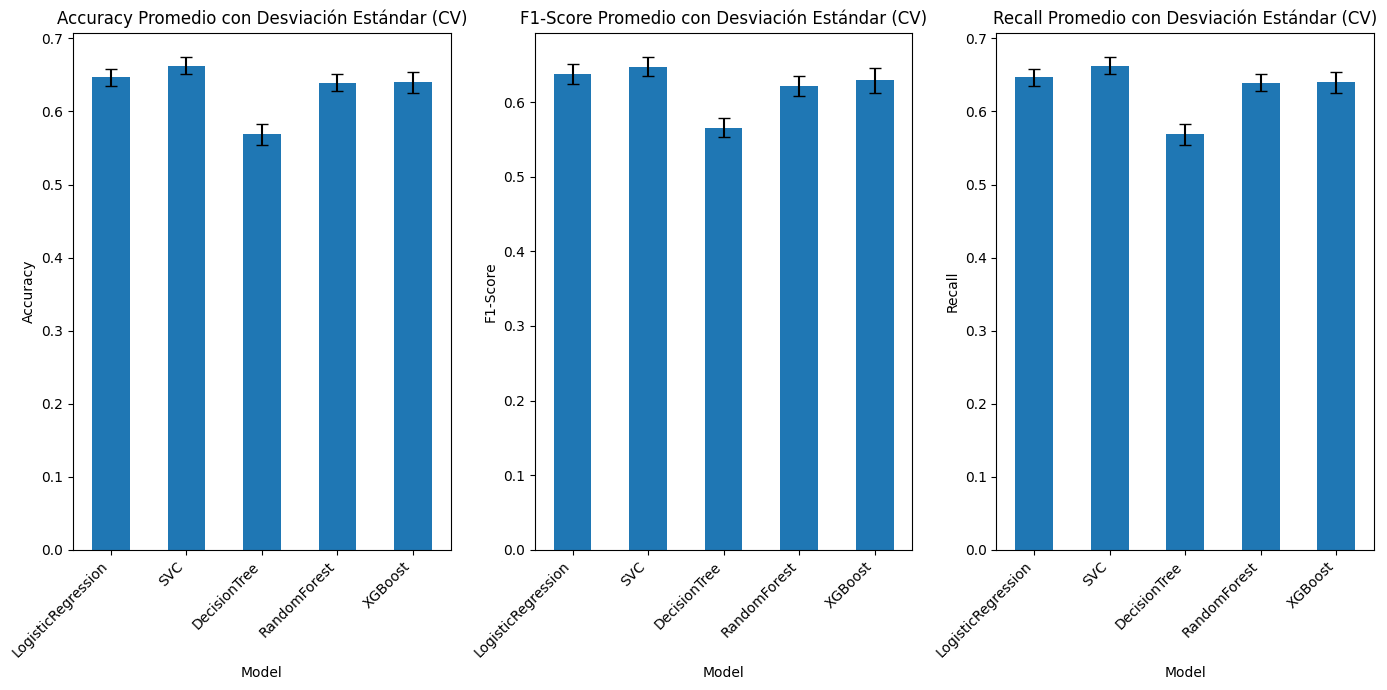

In [67]:
# Visualización de los resultados de la validación cruzada
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
df_results_crossvalidation.plot(x='Model', y='Accuracy_mean', kind='bar', yerr='Accuracy_std', capsize=4, ax=plt.gca(), legend=False)
plt.title('Accuracy Promedio con Desviación Estándar (CV)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
df_results_crossvalidation.plot(x='Model', y='F1_Score_mean', kind='bar', yerr='F1_Score_std', capsize=4, ax=plt.gca(), legend=False)
plt.title('F1-Score Promedio con Desviación Estándar (CV)')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
df_results_crossvalidation.plot(x='Model', y='Recall_mean', kind='bar', yerr='Recall_std', capsize=4, ax=plt.gca(), legend=False)
plt.title('Recall Promedio con Desviación Estándar (CV)')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [68]:
# Verificar el precision_score por cada clase
# Convertir índices codificados a etiquetas reales
etiquetas_reales = le.inverse_transform(labels)
precision_labels_df = pd.DataFrame(precision_labels_cv, index=etiquetas_reales)
precision_labels_df.index.name = "Clase Real"
precision_labels_df.columns.name = "Modelo"
print("Precisión por etiqueta (promedio validación cruzada con etiquetas reales):")
display(precision_labels_df)

Precisión por etiqueta (promedio validación cruzada con etiquetas reales):


Modelo,LogisticRegression,SVC,DecisionTree,RandomForest,XGBoost
Clase Real,,,,,
A,0.066667,0.000000,0.000000,0.000000,0.000000
B,0.602475,0.637196,0.496759,0.615330,0.600723
H,0.528464,0.552998,0.461934,0.527557,0.540669
N,0.500000,0.100000,0.068571,0.000000,0.250000
O,0.600000,0.800000,0.152302,0.583333,0.500000
W,0.718102,0.709156,0.675861,0.684120,0.699646


#### Compara hold out vs cross validation

In [69]:
df_holdout_renamed = df_results_holdout[['Model', 'Accuracy']].copy()
df_cv_renamed = df_results_crossvalidation[['Model', 'Accuracy_mean']].copy()


In [70]:
# Merge con sufijos automáticos
df_compare = pd.merge(
    df_holdout_renamed,
    df_cv_renamed,
    on='Model',
)

df_compare.rename(columns={'Accuracy': 'Accuracy_holdout', 'Accuracy_mean': 'Accuracy_mean_CV'}, inplace=True)

df_compare


,Model,Accuracy_holdout,Accuracy_mean_CV
0,LogisticRegression,0.651709,0.646581
1,SVC,0.655983,0.662393
2,DecisionTree,0.585470,0.568803
3,RandomForest,0.623932,0.639316
4,XGBoost,0.664530,0.640171


Index(['Model', 'Accuracy_holdout', 'Accuracy_mean_CV'], dtype='object')


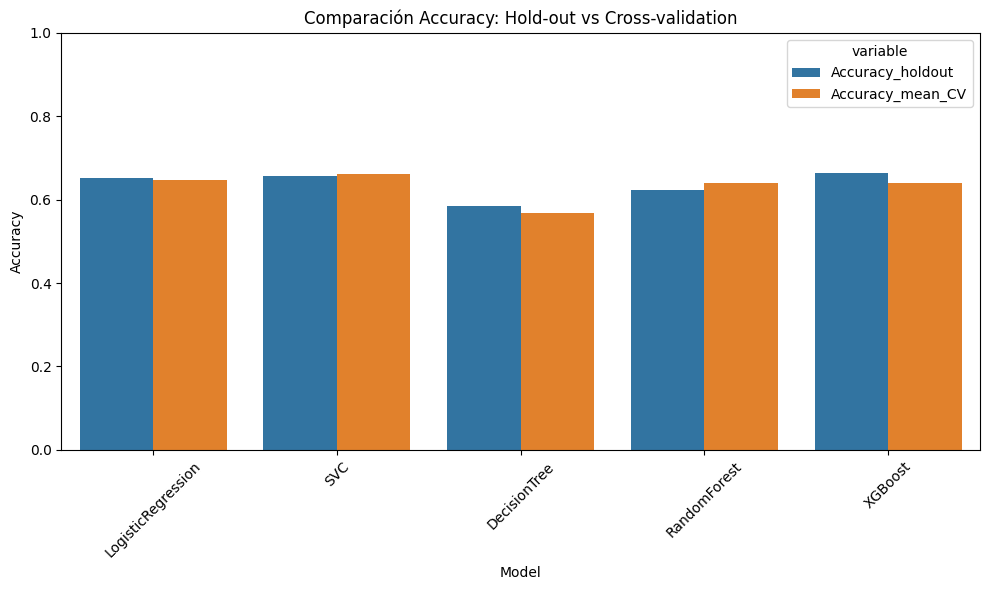

In [71]:
# Verifica que las columnas existen
print(df_compare.columns)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_compare.melt(id_vars='Model', value_vars=['Accuracy_holdout', 'Accuracy_mean_CV']),
    x='Model', y='value', hue='variable'
)
plt.title('Comparación Accuracy: Hold-out vs Cross-validation')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se dejo finalmente el modelo XBBoost con hold out, por tener los mejores valores en

## Explicabilidad

<Figure size 640x480 with 0 Axes>

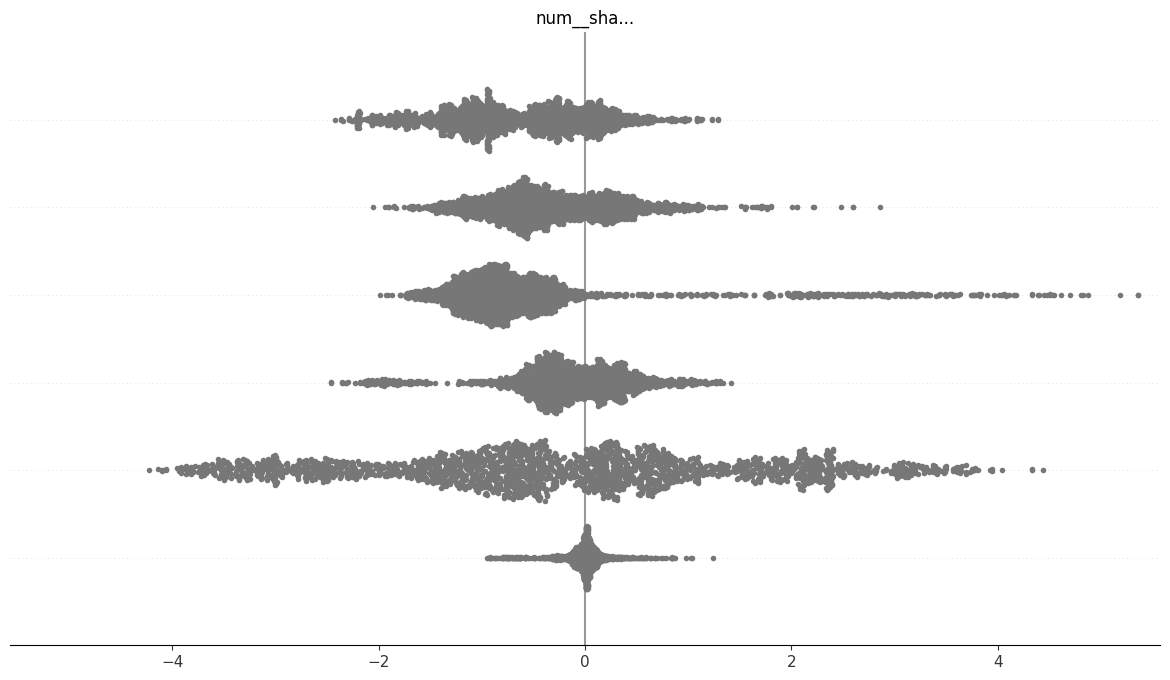

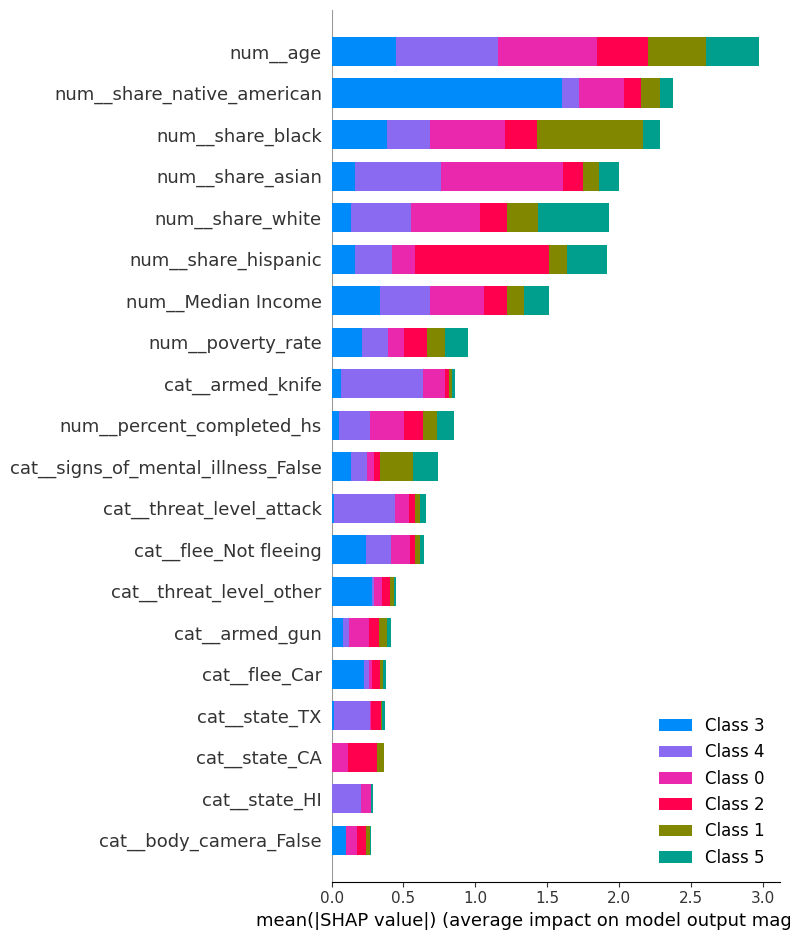

In [72]:
# Entrenar modelo fuera del pipeline
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(preprocessor.fit_transform(X_train_over), y_train_over)

# Aplicar preprocesamiento manualmente al test para SHAP
X_transformed = preprocessor.transform(X_train_over)

# Obtener nombres de las variables transformadas
feature_names = preprocessor.get_feature_names_out()

# Crear explainer
explainer = shap.TreeExplainer(xgb_model)

# Calcular valores SHAP
shap_values = explainer.shap_values(X_transformed)

# Mostrar gráfico resumen
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

# Mostrar gráfico de barras (importancia global)
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, plot_type="bar")